In [87]:
#Dependencies:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.stats import linregress
import time
import json
import os
from pathlib import Path
import hvplot.pandas
import contextily as ctx

#Files to load
airline_data_to_load = Path("Resources/airlines.csv")
airport_data_to_load = Path("Resources/airports.csv")
flights_data_to_load = Path("Resources/flights200501.csv")

#Read the data and store it in a Pandas dataframe
airline_data = pd.read_csv(airline_data_to_load)
airport_data = pd.read_csv(airport_data_to_load)
flights_data = pd.read_csv(flights_data_to_load)

#Clean the data to have same column names
airline_data.rename(columns={"AIRLINE": "AIRLINE_NAME"}, inplace=True)
airline_data.rename(columns={"IATA_CODE": "AIRLINE"}, inplace=True)
airport_data.rename(columns={"IATA_CODE": "ORIGIN_AIRPORT"}, inplace=True)

#Combine the data into a single dataframe
flight_data_complete = pd.merge(flights_data, airline_data, on="AIRLINE", how="left")
flight_data_complete = pd.merge(flight_data_complete, airport_data, on="ORIGIN_AIRPORT", how="left")
flight_data_complete

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,31,6,B6,839,N658JB,JFK,BQN,2359,2359.0,0.0,18.0,17.0,221,200.0,179.0,1576,416.0,3.0,440,419.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,JetBlue Airways,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
469964,2015,1,31,6,DL,1887,N855NW,SEA,DTW,2359,2359.0,0.0,16.0,15.0,252,239.0,209.0,1927,644.0,14.0,711,658.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,2.0,3.0,35.0,37.0,192,212.0,168.0,1506,525.0,9.0,511,534.0,23.0,0,0,NaN,21.0,0.0,2.0,0.0,0.0,Frontier Airlines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700
469966,2015,1,31,6,F9,422,N954FR,DEN,ATL,2359,2359.0,0.0,40.0,39.0,162,191.0,141.0,1199,500.0,10.0,441,510.0,29.0,0,0,NaN,29.0,0.0,0.0,0.0,0.0,Frontier Airlines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700


In [3]:
#Clean the data and fill the missing values with 0
flight_data_cleaned=flight_data_complete.fillna("0")
flight_data_cleaned

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,0,US Airways Inc.,San Francisco International Airport,San Francisco,CA,USA,37.619,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,0,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,31,6,B6,839,N658JB,JFK,BQN,2359,...,0,0,0,JetBlue Airways,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
469964,2015,1,31,6,DL,1887,N855NW,SEA,DTW,2359,...,0,0,0,Delta Air Lines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,...,2.0,0.0,0.0,Frontier Airlines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.667
469966,2015,1,31,6,F9,422,N954FR,DEN,ATL,2359,...,0.0,0.0,0.0,Frontier Airlines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.667


In [4]:
#Check to insure there are no null values
null_count= flight_data_cleaned.isnull().sum()
null_count

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
AIRLINE_NAME           0
AIRPORT                0
CITY                   0
STATE                  0
COUNTRY                0
LATITUDE               0
LONGITUDE              0
dtype: int64

In [5]:
#What is the average delay time for each airline

#Create a new dataframe that contains the airline delays that are greater than zero
flight_data_cleaned['AIRLINE_DELAY'] = flight_data_cleaned['AIRLINE_DELAY'].astype(float)
flights_delayed_df = flight_data_cleaned.loc[flight_data_cleaned['AIRLINE_DELAY'] > 0]
flights_delayed_df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,...,15.0,0.0,0.0,Hawaiian Airlines Inc.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
52,2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,...,85.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
55,2015,1,1,4,B6,2276,N646JB,SJU,BDL,438,...,72.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
73,2015,1,1,4,US,425,N174US,PDX,PHX,520,...,60.0,0.0,0.0,US Airways Inc.,Portland International Airport,Portland,OR,USA,45.58872,-122.5975
74,2015,1,1,4,AA,89,N3KVAA,IAH,MIA,520,...,54.0,0.0,0.0,American Airlines Inc.,George Bush Intercontinental Airport,Houston,TX,USA,29.98047,-95.33972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469912,2015,1,31,6,B6,2002,N317JB,JFK,BUF,2310,...,8.0,8.0,0.0,JetBlue Airways,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
469920,2015,1,31,6,B6,912,N516JB,LAS,JFK,2318,...,18.0,0.0,0.0,JetBlue Airways,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
469924,2015,1,31,6,B6,729,N510JB,MCO,BQN,2325,...,15.0,25.0,0.0,JetBlue Airways,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
469940,2015,1,31,6,B6,688,N643JB,LAX,BOS,2349,...,18.0,11.0,0.0,JetBlue Airways,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [15]:
#View all columns in the dataframe 

pd.set_option('display.max_columns', None)
print(flights_delayed_df)

        YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
35      2015      1    1            4      HA             17      N389HA   
52      2015      1    1            4      B6           2134      N307JB   
55      2015      1    1            4      B6           2276      N646JB   
73      2015      1    1            4      US            425      N174US   
74      2015      1    1            4      AA             89      N3KVAA   
...      ...    ...  ...          ...     ...            ...         ...   
469912  2015      1   31            6      B6           2002      N317JB   
469920  2015      1   31            6      B6            912      N516JB   
469924  2015      1   31            6      B6            729      N510JB   
469940  2015      1   31            6      B6            688      N643JB   
469965  2015      1   31            6      F9            300      N218FR   

       ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE DEPARTURE_TIME  \
35    

In [40]:
#How many total delays are there for each month of the year?

month_df=flights_delayed_df.groupby("MONTH")[["AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].sum(numeric_only=True)
month_df

,AIRLINE_DELAY
MONTH,
1,1708155.0


In [21]:
#What are the types of delays?

delay_df= flights_delayed_df[["AIR_SYSTEM_DELAY", "SECURITY_DELAY",  "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]]
delay_df

,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
35,0.0,0.0,15.0,0.0,0.0
52,0.0,0.0,85.0,0.0,0.0
55,17.0,0.0,72.0,0.0,0.0
73,0.0,0.0,60.0,0.0,0.0
74,0.0,0.0,54.0,0.0,0.0
...,...,...,...,...,...
469912,0.0,0.0,8.0,8.0,0.0
469920,0.0,0.0,18.0,0.0,0.0
469924,0.0,0.0,15.0,25.0,0.0
469940,1.0,0.0,18.0,11.0,0.0


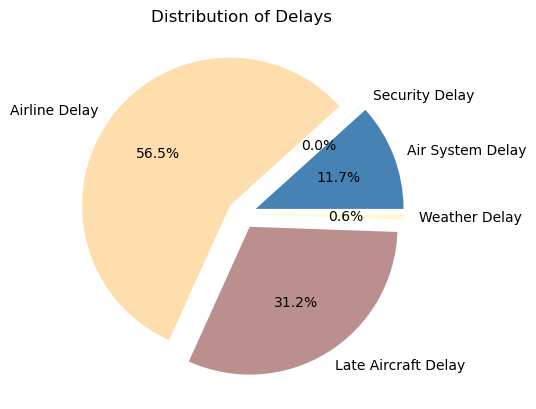

In [38]:
# Calculate the total sum of delays
total_delays = delay_df.sum()

# Create pie chart
labels = ["Air System Delay", "Security Delay", "Airline Delay", "Late Aircraft Delay", "Weather Delay"]
values = total_delays.values
colors = ["steelblue", "powderblue", "navajowhite", "rosybrown", "lemonchiffon"]
explode = [0.1, 0.1, 0.1, 0.1, 0.1] 
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('Distribution of Delays')
plt.show()

In [20]:
airsystem_delay= delay_df["AIR_SYSTEM_DELAY"].sum()
airsystem_delay

353080.0

In [7]:
#What is the average delay time for each airline

#Find the average delay time for each airline using groupby 
average_delay= flights_delayed_df.groupby(["AIRLINE"])["AIRLINE_DELAY"].mean()
average_delay_df=pd.DataFrame(average_delay)
average_df = average_delay_df.reset_index().sort_values(['AIRLINE_DELAY'],ascending=False)
average_df

,AIRLINE,AIRLINE_DELAY
9,OO,50.677010
3,DL,41.717744
1,AS,41.426724
4,EV,40.692335
0,AA,39.939424
7,MQ,35.863570
10,UA,32.760287
12,VX,31.059006
11,US,30.685219
5,F9,30.489459


Text(0, 0.5, 'Avg. delay in minutes')

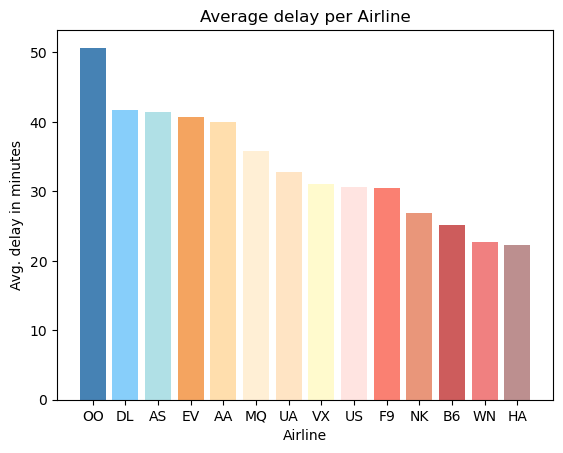

In [17]:
#Graph for average delay for each airline

colors = ["steelblue", "lightskyblue", "powderblue", "sandybrown", "navajowhite", "papayawhip", "bisque", "lemonchiffon", "mistyrose", "salmon", "darksalmon", "indianred", "lightcoral","rosybrown"]
plt.bar(average_df['AIRLINE'], average_df['AIRLINE_DELAY'], color=colors)
plt.title("Average delay per Airline")
plt.xlabel("Airline")
plt.ylabel("Avg. delay in minutes")

In [9]:
#Find the average delay of each origin airport

origin_delay= flights_delayed_df.groupby(["ORIGIN_AIRPORT"])["AIRLINE_DELAY"].mean()
origin_delay

ORIGIN_AIRPORT
ABE     30.214286
ABI     46.720000
ABQ     36.982857
ABR    253.200000
ABY     50.625000
          ...    
VEL     96.000000
VLD     43.777778
VPS     45.791667
XNA     63.076923
YUM    102.200000
Name: AIRLINE_DELAY, Length: 297, dtype: float64

In [10]:
origin_delay.describe()

count    297.000000
mean      49.748047
std       45.411164
min        1.000000
25%       27.375000
50%       37.766667
75%       55.808511
max      415.666667
Name: AIRLINE_DELAY, dtype: float64

In [11]:
#What origin airport has the highest amount of delayed flights

max_origin_delay = flights_delayed_df.groupby("ORIGIN_AIRPORT")["AIRLINE_DELAY"].max()
max_delay = max_origin_delay.max()
origin_airport_with_max_delay = max_origin_delay.idxmax()
print(f"The origin airport with the maximum delay is {origin_airport_with_max_delay} with a delay of {max_delay}")

The origin airport with the maximum delay is BHM with a delay of 1971.0


In [12]:
#Find the average delay of each destination airport

destination_delay= flights_delayed_df.groupby(["DESTINATION_AIRPORT"])["AIRLINE_DELAY"].mean()
destination_delay

DESTINATION_AIRPORT
ABE    37.785714
ABI    28.744186
ABQ    23.734300
ABR    41.000000
ABY    65.400000
         ...    
VPS    39.533333
WRG    16.000000
XNA    37.973913
YAK     6.500000
YUM    50.818182
Name: AIRLINE_DELAY, Length: 310, dtype: float64

In [13]:
#What destination airport has the highest amount of delayed flights

max_destination_delay = flights_delayed_df.groupby("DESTINATION_AIRPORT")["AIRLINE_DELAY"].max()
max_delay = max_origin_delay.max()
destination_airport_with_max_delay = max_destination_delay.idxmax()
print(f"The destination airport with the maximum delay is {destination_airport_with_max_delay} with a delay of {max_delay}")

The destination airport with the maximum delay is DFW with a delay of 1971.0


In [42]:
# convert data to numeric values

flight_data_cleaned['AIRLINE_DELAY'] = pd.to_numeric(flight_data_cleaned['AIRLINE_DELAY'], errors='coerce')
flight_data_cleaned['AIR_SYSTEM_DELAY'] = pd.to_numeric(flight_data_cleaned['AIR_SYSTEM_DELAY'], errors='coerce')
flight_data_cleaned['SECURITY_DELAY'] = pd.to_numeric(flight_data_cleaned['SECURITY_DELAY'], errors='coerce')
flight_data_cleaned['LATE_AIRCRAFT_DELAY'] = pd.to_numeric(flight_data_cleaned['LATE_AIRCRAFT_DELAY'], errors='coerce')
flight_data_cleaned['WEATHER_DELAY'] = pd.to_numeric(flight_data_cleaned['WEATHER_DELAY'], errors='coerce')

In [43]:
# crete new df where delay is > 0 
flights_all_delayed_df= flight_data_cleaned[(flight_data_cleaned['AIRLINE_DELAY'] > 1) |
                  (flight_data_cleaned['AIR_SYSTEM_DELAY'] > 1) |
                  (flight_data_cleaned['SECURITY_DELAY'] > 1) |
                  (flight_data_cleaned['LATE_AIRCRAFT_DELAY'] > 1) |
                  (flight_data_cleaned['WEATHER_DELAY'] > 1)]
flights_all_delayed_df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
27,2015,1,1,4,NK,597,N528NK,MSP,FLL,115,127.0,12.0,14.0,141.0,207,220.0,166.0,1487,527.0,40.0,542,607.0,25.0,0,0,0,25.0,0.0,0.0,0.0,0.0,Spirit Air Lines,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692
30,2015,1,1,4,NK,168,N629NK,PHX,ORD,125,237.0,72.0,9.0,246.0,204,175.0,156.0,1440,622.0,10.0,549,632.0,43.0,0,0,0,43.0,0.0,0.0,0.0,0.0,Spirit Air Lines,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,145.0,0.0,16.0,201.0,370,385.0,361.0,2762,602.0,8.0,555,610.0,15.0,0,0,0,0.0,0.0,15.0,0.0,0.0,Hawaiian Airlines Inc.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
50,2015,1,1,4,B6,1030,N239JB,BQN,MCO,307,304.0,-3.0,25.0,329.0,173,196.0,160.0,1129,509.0,11.0,500,520.0,20.0,0,0,0,20.0,0.0,0.0,0.0,0.0,JetBlue Airways,Rafael Hernández Airport,Aguadilla,PR,USA,18.49486,-67.12944
52,2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,535.0,95.0,9.0,544.0,185,175.0,163.0,1189,727.0,3.0,605,730.0,85.0,0,0,0,0.0,0.0,85.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469945,2015,1,31,6,AS,121,N763AS,SEA,ANC,2350,136.0,106.0,9.0,145.0,230,202.0,189.0,1448,354.0,4.0,240,358.0,78.0,0,0,0,0.0,0.0,0.0,78.0,0.0,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
469953,2015,1,31,6,B6,778,N594JB,LAS,BOS,2355,23.0,28.0,29.0,52.0,290,296.0,260.0,2381,812.0,7.0,745,819.0,34.0,0,0,0,6.0,0.0,0.0,28.0,0.0,JetBlue Airways,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
469959,2015,1,31,6,B6,98,N535JB,DEN,JFK,2357,21.0,24.0,66.0,127.0,211,255.0,182.0,1626,629.0,7.0,528,636.0,68.0,0,0,0,44.0,0.0,0.0,11.0,13.0,JetBlue Airways,Denver International Airport,Denver,CO,USA,39.85841,-104.667
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,2.0,3.0,35.0,37.0,192,212.0,168.0,1506,525.0,9.0,511,534.0,23.0,0,0,0,21.0,0.0,2.0,0.0,0.0,Frontier Airlines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.667


In [44]:
#What is the average delay time for each airport for each of the five delays

average_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["AIRLINE_DELAY"].mean()
average_air_system_delay= flights_all_delayed_df.groupby(["AIRPORT"])['AIR_SYSTEM_DELAY'].mean()
average_security_delay= flights_all_delayed_df.groupby(["AIRPORT"])["SECURITY_DELAY"].mean()
average_late_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["LATE_AIRCRAFT_DELAY"].mean()
average_weather_delay= flights_all_delayed_df.groupby(["AIRPORT"])["WEATHER_DELAY"].mean()

In [63]:
#What is the sum of the delays for each of the five delays

sum_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["AIRLINE_DELAY"].sum()
sum_air_system_delay= flights_all_delayed_df.groupby(["AIRPORT"])['AIR_SYSTEM_DELAY'].sum()
sum_security_delay= flights_all_delayed_df.groupby(["AIRPORT"])["SECURITY_DELAY"].sum()
sum_late_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["LATE_AIRCRAFT_DELAY"].sum()
sum_weather_delay= flights_all_delayed_df.groupby(["AIRPORT"])["WEATHER_DELAY"].sum()

In [47]:
flights_delay_averages = pd.DataFrame({
                                    "Airline Delay AVG": average_airline_delay,
                                    "Air System Delay AVG": average_air_system_delay,
                                    "Security Delay AVG": average_security_delay,
                                    "Late Aircraft Delay AVG": average_late_airline_delay,
                                    "Weather Delay AVG": average_weather_delay
})

In [64]:
flights_delay_sums = pd.DataFrame({
                                    "Airline Delay Sum": sum_airline_delay,
                                    "Air System Delay Sum": sum_air_system_delay,
                                    "Security Delay Sum": sum_security_delay,
                                    "Late Aircraft Delay Sum": sum_late_airline_delay,
                                    "Weather Delay Sum": sum_weather_delay
})

In [65]:
# Create a df for the sum of the delays by each individual airport

delay_sums = flights_delay_sums.groupby('AIRPORT')[['Airline Delay Sum', 'Air System Delay Sum', 'Security Delay Sum', 'Late Aircraft Delay Sum', 'Weather Delay Sum']].sum()
delay_sums['TOTAL DELAYS (minutes)'] = delay_sums[['Airline Delay Sum', 'Air System Delay Sum', 'Security Delay Sum', 'Late Aircraft Delay Sum', 'Weather Delay Sum']].sum(axis=1)
delay_sums_df = pd.DataFrame(delay_sums ['TOTAL DELAYS (minutes)'])
delay_sums_df

,TOTAL DELAYS (minutes)
AIRPORT,
Aberdeen Regional Airport,1682.0
Abilene Regional Airport,2787.0
Abraham Lincoln Capital Airport,1702.0
Adak Airport,54.0
Akron-Canton Regional Airport,5026.0
...,...
Yakutat Airport,360.0
Yampa Valley Airport (Yampa Valley Regional),2669.0
Yeager Airport,3244.0


In [66]:
#Find the top 5 airports with the highest number of total delays 
high_airport=delay_sums_df.sort_values(by = "TOTAL DELAYS (minutes)", axis=0,ascending=False).head(5)
high_airport['Airport'] = high_airport.index
high_airport

,TOTAL DELAYS (minutes),Airport
AIRPORT,,
Chicago O'Hare International Airport,490097.0,Chicago O'Hare International Airport
Dallas/Fort Worth International Airport,293062.0,Dallas/Fort Worth International Airport
Denver International Airport,271460.0,Denver International Airport
Hartsfield-Jackson Atlanta International Airport,218321.0,Hartsfield-Jackson Atlanta International Airport
Los Angeles International Airport,170114.0,Los Angeles International Airport


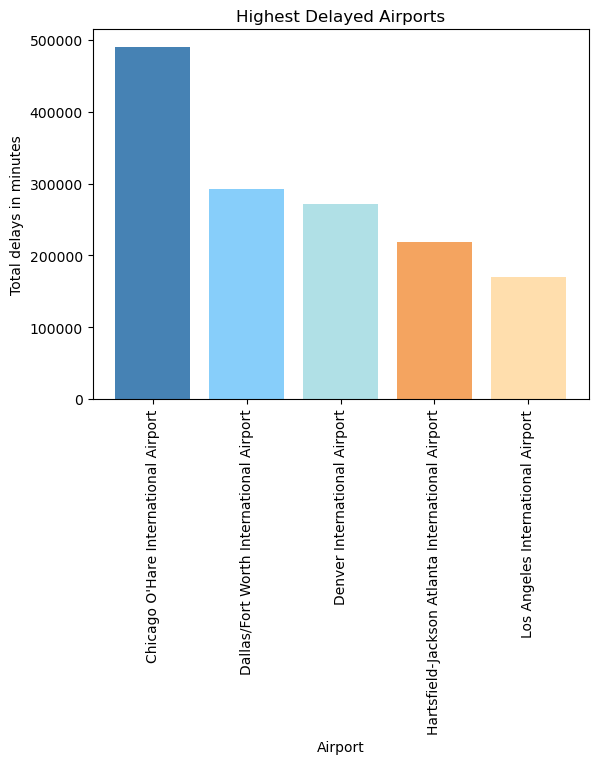

In [67]:
#Create a chart for the highest delayed airports
colors = ["steelblue", "lightskyblue", "powderblue", "sandybrown", "navajowhite"] 
plt.bar(high_airport["Airport"], high_airport["TOTAL DELAYS (minutes)"], color=colors)
plt.title("Highest Delayed Airports")
plt.xlabel("Airport")
plt.ylabel("Total delays in minutes")
plt.xticks(rotation=90)
plt.show()

In [70]:
#Find the top 5 airports with the lowest number of total delays 
low_airport= delay_sums_df.sort_values(by = "TOTAL DELAYS (minutes)", axis=0,ascending=True).head(5)
low_airport['Airport'] = low_airport.index
low_airport

,TOTAL DELAYS (minutes),Airport
AIRPORT,,
Lewiston-Nez Perce County Airport,17.0,Lewiston-Nez Perce County Airport
Adak Airport,54.0,Adak Airport
Magic Valley Regional Airport (Joslin Field),59.0,Magic Valley Regional Airport (Joslin Field)
Pago Pago International Airport (Tafuna Airport),79.0,Pago Pago International Airport (Tafuna Airport)
Elko Regional Airport,93.0,Elko Regional Airport


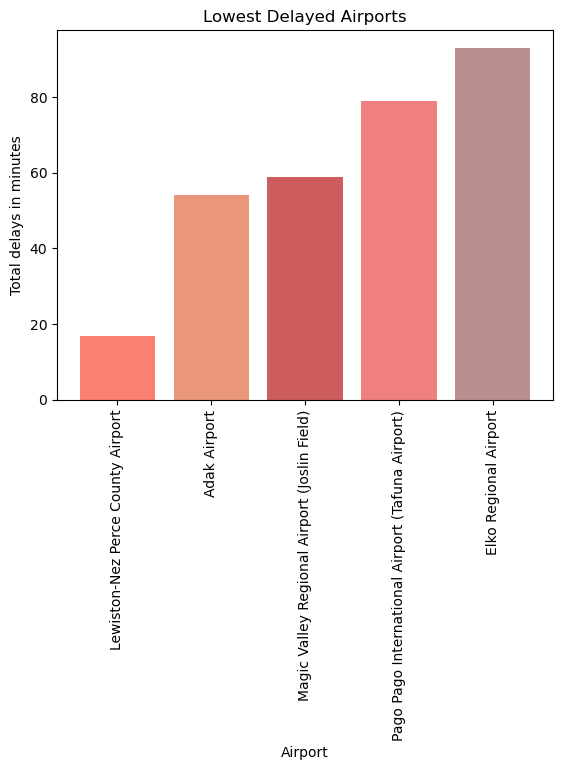

In [69]:
#Create a chart for the lowest delayed airports
colors = ["salmon", "darksalmon", "indianred", "lightcoral","rosybrown"] 
plt.bar(low_airport["Airport"], low_airport["TOTAL DELAYS (minutes)"], color=colors)
plt.title("Lowest Delayed Airports")
plt.xlabel("Airport")
plt.ylabel("Total delays in minutes")
plt.xticks(rotation=90)
plt.show()

In [76]:
# Create empty sets to store unique airports
processed_airports = set()

# Iterate through the DataFrame
for index, row in flights_all_delayed_df.iterrows():
    airport = row['AIRPORT']
    if airport == "Chicago O'Hare International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at CHI is {latitude},{longitude}")
        # Store latitude and longitude in the lists
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)  # Add airport to the set of processed airports
    elif airport == "Dallas/Fort Worth International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at DFX is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "Denver International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at DEN is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "Hartsfield-Jackson Atlanta International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at ATL is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "Los Angeles International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at LAX is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)


The Lat , Lon at DFX is 32.89595,-97.0372
The Lat , Lon at DEN is 39.85841,-104.667
The Lat , Lon at CHI is 41.9796,-87.90446
The Lat , Lon at ATL is 33.64044,-84.42694
The Lat , Lon at LAX is 33.94254,-118.40807


In [97]:
airport_df= pd.DataFrame(processed_airports)
airport_df

,0
0,Denver International Airport
1,Chicago O'Hare International Airport
2,Dallas/Fort Worth International Airport
3,Los Angeles International Airport
4,Hartsfield-Jackson Atlanta International Airport


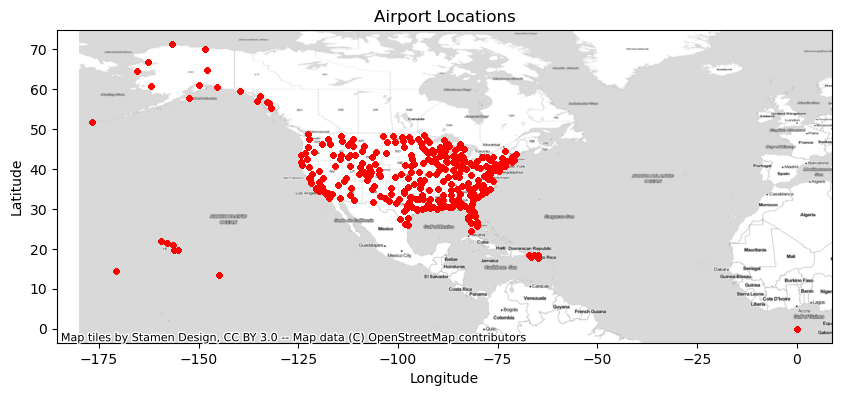

In [89]:
flight_data_cleaned['LONGITUDE'] = flight_data_cleaned['LONGITUDE'].astype(float)
flight_data_cleaned['LATITUDE'] = flight_data_cleaned['LATITUDE'].astype(float)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(flight_data_cleaned['LONGITUDE'], flight_data_cleaned['LATITUDE'], color='red', s=10)

# Add map tiles
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Customize the map
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airport Locations')

# Show the map
plt.show()

In [84]:

map_plot_2 = flights_all_delayed_df.hvplot.points(
    "LONGITUDE",
    "LATITUDE",
    geo = True,
    frame_width = 800,
    frame_height = 600,
    tiles = "EsriImagery",
    size = "Total delays in minutes",
    scale = 0.5,
    color = "AIRPORT"
)
# Display the map plot
map_plot_2

TypeError: '<' not supported between instances of 'float' and 'str'

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [LONGITUDE,LATITUDE]   (AIRPORT)